In [205]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Machine learning supervisado
# ==============================================================================
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import xgboost

# Transformación logarítmica
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Guardar modelos
# ==============================================================================
import pickle

In [206]:
df = pd.read_csv('./data/flight_delays_train.csv')
df.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [208]:
df['Month'].unique()

array(['c-8', 'c-4', 'c-9', 'c-11', 'c-10', 'c-1', 'c-7', 'c-6', 'c-5',
       'c-3', 'c-12', 'c-2'], dtype=object)

In [209]:
# Elimino las letras c- de month, dayofmonth y dayofweek y lo paso a numerico
df['Month'] = df['Month'].str.split('-').str[1].astype(int)
df['DayofMonth'] = df['DayofMonth'].str.split('-').str[1].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].str.split('-').str[1].astype(int)
df.rename(columns = {'DayOfWeek':'DayofWeek'})
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [210]:
# Aseguro que aeropuerto de origen y de destino no sean iguales, ya que sería un error
df = df[df['Origin'] != df['Dest']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  int64 
 1   DayofMonth         100000 non-null  int64 
 2   DayOfWeek          100000 non-null  int64 
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


## EDA

#### Distribución del target

(array([80956.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 19044.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

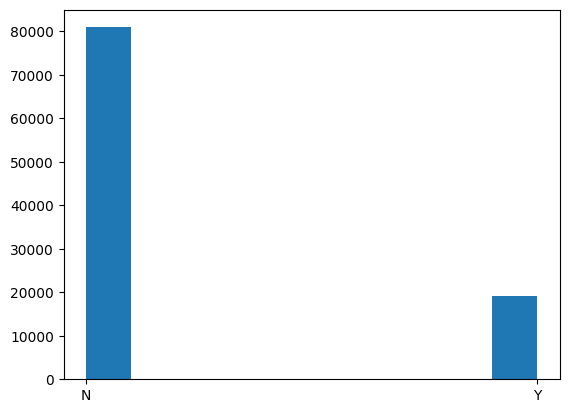

In [211]:
#Distribución del target.
plt.hist(df['dep_delayed_15min'])

### Análisis univariante

Análisis de la distribución de la variable mes

Text(0.5, 1.0, 'Distribution of Month')

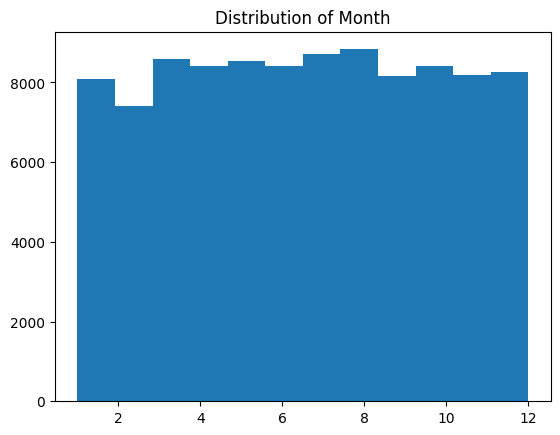

In [212]:
plt.hist(df['Month'], bins = 12)
plt.title('Distribution of Month')

Se dispone de datos de un número de vuelos muy similar para cada mes.

Análisis de las aerolíneas y aeropuertos de origen y destino

In [213]:
airlines = df['UniqueCarrier'].value_counts()
print(airlines)
print(airlines.describe())

UniqueCarrier
WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: count, dtype: int64
count       22.000000
mean      4545.454545
std       3683.306960
min        234.000000
25%       1493.000000
50%       4132.000000
75%       6777.500000
max      15082.000000
Name: count, dtype: float64


Hay datos de vuelo de 22 aerolíneas. De media se tienen datos de 4545 vuelos de cada aerolínea, pero la desviación estándar es muy grande, por lo que hay aerolíneas con muchos vuelos y otras con muy pocos.

Text(0, 0.5, 'Nº of flights in the dataset')

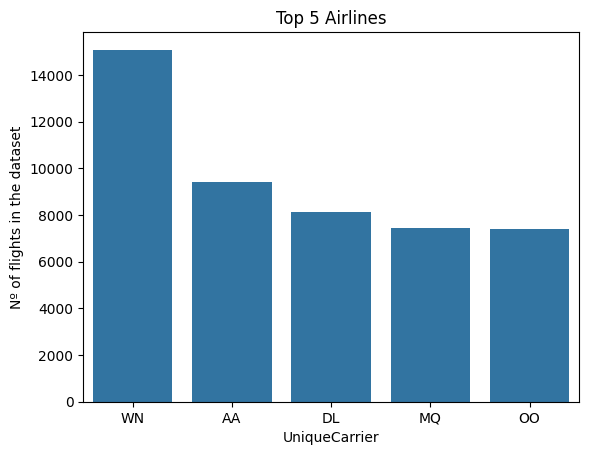

In [214]:
sns.barplot(airlines.head(5))
plt.title('Top 5 Airlines')
plt.ylabel('Nº of flights in the dataset')

In [215]:
airport_origin = df['Origin'].value_counts()
airport_origin.describe()

count     289.000000
mean      346.020761
std       739.424875
min         1.000000
25%        23.000000
50%        67.000000
75%       272.000000
max      5834.000000
Name: count, dtype: float64

Se tienen datos de 289 aeropuertos origen. Hay registros que aparecen muy pocas veces y otros que son muy comunes.

Text(0, 0.5, 'Nº of flights in the dataset')

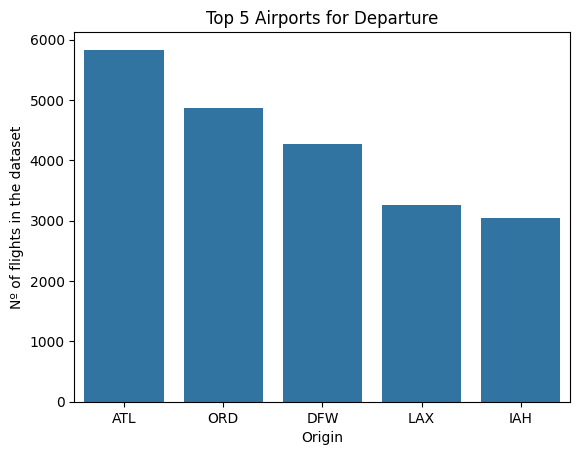

In [216]:
sns.barplot(airport_origin.head(5))
plt.title('Top 5 Airports for Departure')
plt.ylabel('Nº of flights in the dataset')

In [217]:
airport_dest = df['Dest'].value_counts()
airport_dest.describe()

count     289.000000
mean      346.020761
std       739.527162
min         1.000000
25%        24.000000
50%        65.000000
75%       268.000000
max      5795.000000
Name: count, dtype: float64

Text(0, 0.5, 'Nº of flights in the dataset')

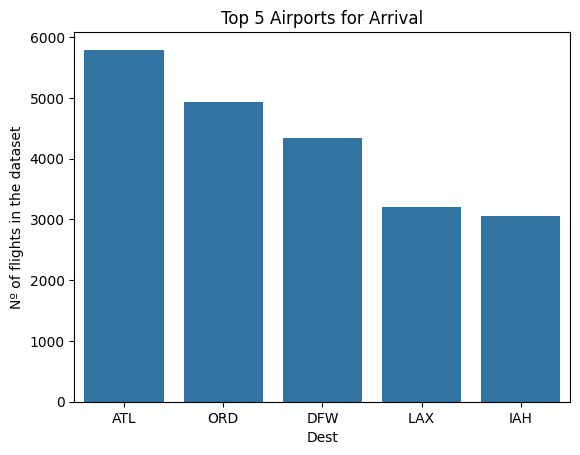

In [218]:
sns.barplot(airport_dest.head(5))
plt.title('Top 5 Airports for Arrival')
plt.ylabel('Nº of flights in the dataset')

<Axes: ylabel='Distance'>

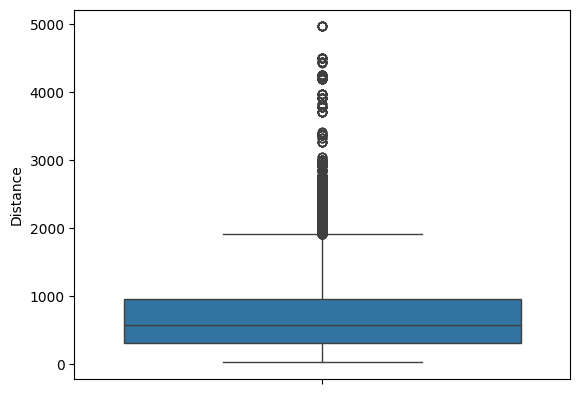

In [219]:
sns.boxplot(df['Distance'])

In [220]:
df['Distance'].describe()

count    100000.00000
mean        729.39716
std         574.61686
min          30.00000
25%         317.00000
50%         575.00000
75%         957.00000
max        4962.00000
Name: Distance, dtype: float64

## Análisis Bivariante

In [221]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [222]:
vuelos_totales = df.groupby('UniqueCarrier')['dep_delayed_15min'].count()
vuelos_retraso = df[df['dep_delayed_15min'] == 'Y'].groupby('UniqueCarrier')['dep_delayed_15min'].count()

In [223]:
vuelos_totales

UniqueCarrier
AA     9418
AQ      234
AS     2222
B6     1838
CO     4334
DH      966
DL     8128
EV     3930
F9     1006
FL     3039
HA      762
HP     1378
MQ     7443
NW     6403
OH     4594
OO     7390
TZ      446
UA     6876
US     6482
WN    15082
XE     5901
YV     2128
Name: dep_delayed_15min, dtype: int64

In [224]:
airlines_pct_delay = pd.merge(left = vuelos_totales, right = vuelos_retraso, on = 'UniqueCarrier', how = 'inner')
airlines_pct_delay.rename(columns = {'dep_delayed_15min_x': 'Total_flights', 'dep_delayed_15min_y': 'Delayed_flights' }, inplace = True)
airlines_pct_delay['pct_delays'] = round(airlines_pct_delay['Delayed_flights'] / airlines_pct_delay['Total_flights'],4)
airlines_pct_delay.sort_values(by = 'pct_delays', ascending = False, inplace = True)
airlines_pct_delay

,Total_flights,Delayed_flights,pct_delays
UniqueCarrier,,,
EV,3930,1082,0.2753
AS,2222,541,0.2435
FL,3039,736,0.2422
YV,2128,478,0.2246
B6,1838,393,0.2138
WN,15082,3219,0.2134
MQ,7443,1448,0.1945
UA,6876,1322,0.1923
AA,9418,1770,0.1879


<Axes: xlabel='UniqueCarrier', ylabel='pct_delays'>

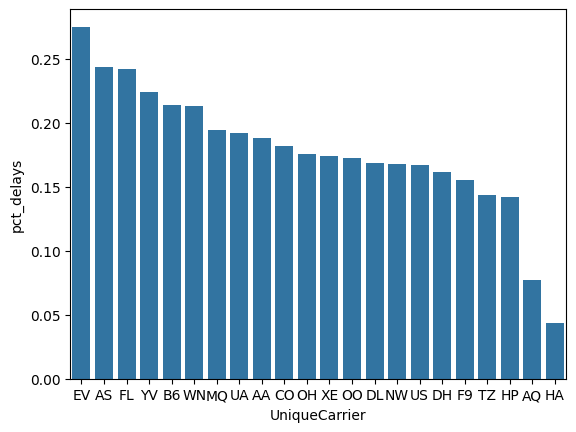

In [225]:
sns.barplot(airlines_pct_delay['pct_delays'])

In [226]:
# Repito el proceso para analizar las diferencias en el porcentaje de vuelos retrasados según el aeropuerto de origen
vuelos_totales = df.groupby('Origin')['dep_delayed_15min'].count()
vuelos_retraso = df[df['dep_delayed_15min'] == 'Y'].groupby('Origin')['dep_delayed_15min'].count()

origin_pct_delay = pd.merge(left = vuelos_totales, right = vuelos_retraso, on = 'Origin', how = 'inner')
origin_pct_delay.rename(columns = {'dep_delayed_15min_x': 'Total_flights', 'dep_delayed_15min_y': 'Delayed_flights' }, inplace = True)
origin_pct_delay['pct_delays'] = round(origin_pct_delay['Delayed_flights'] / origin_pct_delay['Total_flights'],4)
origin_pct_delay.sort_values(by = 'pct_delays', ascending = False, inplace = True)
origin_pct_delay

,Total_flights,Delayed_flights,pct_delays
Origin,,,
GST,1,1,1.0000
ADK,1,1,1.0000
AKN,2,2,1.0000
LWB,4,3,0.7500
BRW,7,5,0.7143
...,...,...,...
BRO,28,1,0.0357
LIH,153,5,0.0327
HLN,31,1,0.0323


## Primer modelo ML

Para este primer modelo no se va a utilizar el aeropuerto origen y destino

In [227]:
df.drop(columns = ['Origin', 'Dest'], inplace = True)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,dep_delayed_15min
0,8,21,7,1934,AA,732,N
1,4,20,3,1548,US,834,N
2,9,2,5,1422,XE,416,N
3,11,25,6,1015,OO,872,N
4,10,7,6,1828,WN,423,Y


Cambio la columna target para sustituir N por 0 e Y por 1

In [228]:
df['dep_delayed_15'] = df['dep_delayed_15min'].apply(lambda x: 0 if x == 'N' else 1)
df.drop(columns = 'dep_delayed_15min', inplace = True)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,dep_delayed_15
0,8,21,7,1934,AA,732,0
1,4,20,3,1548,US,834,0
2,9,2,5,1422,XE,416,0
3,11,25,6,1015,OO,872,0
4,10,7,6,1828,WN,423,1


Sustituyo la variable UniqueCarrier por su porcentaje de retrasos

In [229]:
airlines_pct_delay.head()

,Total_flights,Delayed_flights,pct_delays
UniqueCarrier,,,
EV,3930,1082,0.2753
AS,2222,541,0.2435
FL,3039,736,0.2422
YV,2128,478,0.2246
B6,1838,393,0.2138


In [230]:
df['Airline_pct_delays'] = df['UniqueCarrier'].map(airlines_pct_delay['pct_delays'])
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Distance,dep_delayed_15,Airline_pct_delays
0,8,21,7,1934,AA,732,0,0.1879
1,4,20,3,1548,US,834,0,0.1674
2,9,2,5,1422,XE,416,0,0.1739
3,11,25,6,1015,OO,872,0,0.1728
4,10,7,6,1828,WN,423,1,0.2134


Elimino la columna UniqueCarrier y coloco el target a la derecha del todo

In [231]:
df.drop(columns = 'UniqueCarrier', inplace = True)
df = df[[col for col in df.columns if col != 'dep_delayed_15'] + ['dep_delayed_15']]
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,Airline_pct_delays,dep_delayed_15
0,8,21,7,1934,732,0.1879,0
1,4,20,3,1548,834,0.1674,0
2,9,2,5,1422,416,0.1739,0
3,11,25,6,1015,872,0.1728,0
4,10,7,6,1828,423,0.2134,1


Con el df ya preparado, divido en X e Y y en train y test y entreno el modelo

In [232]:
X = df.drop(columns = 'dep_delayed_15')
y = df['dep_delayed_15']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [233]:
# Crear el pipeline con XGBClassifier
pipe = Pipeline(steps=[
    ('classifier', xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Definir el espacio de búsqueda para XGBClassifier
xgboost_param = {
    'classifier': [xgboost.XGBClassifier()],
    'classifier__n_estimators': [100, 125, 150],  # Número de árboles
    'classifier__learning_rate': [0.01, 0.05, 0.08],  # Tasa de aprendizaje
    'classifier__max_depth': [4, 5, 6]  # Profundidad máxima
}

# Definir el espacio de búsqueda para RandomForestClassifier
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    "classifier__n_estimators": [100, 200],  # Número de árboles
    'classifier__max_depth': [5, 7]  # Profundidad máxima
}

# Combinar ambos espacios de búsqueda
search_space = [xgboost_param, random_forest_params]

# Configurar RandomizedSearchCV con ROC AUC
clf = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=search_space,
    n_iter=10,
    scoring='roc_auc',  # Cambiamos la métrica a ROC AUC
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Mostrar los mejores parámetros y modelo
print("Best Parameters:", clf.best_params_)
print("Best Model:", clf.best_estimator_)

# Evaluar en el conjunto de entrenamiento
y_pred_proba_train = clf.best_estimator_.predict_proba(X_train)[:, 1]  # Probabilidades de la clase positiva
roc_auc_train = round(roc_auc_score(y_train, y_pred_proba_train), 3)
print("ROC AUC (Train):", roc_auc_train)

# Evaluar en el conjunto de prueba
y_pred_proba_test = clf.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_test = round(roc_auc_score(y_test, y_pred_proba_test), 3)
print("ROC AUC (Test):", roc_auc_test)

Best Parameters: {'classifier__n_estimators': 150, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.08, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}
Best Model: Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callback

In [234]:
model_1 = clf.best_estimator_.fit(X, y)

Ejecuto el modelo 1 con los datos de submission

In [235]:
# para comprobar el formato en el que tiene que ir el submit:
df_submission_sample = pd.read_csv('./data/sample_submission.csv')
df_submission_sample.head()

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732


In [236]:
df_test = pd.read_csv('./data/flight_delays_test.csv')
df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


A continuación hay que aplicar al dataframe de test exactamente las mismas transformaciones que al df de train

In [237]:
# Elimino las letras c- de month, dayofmonth y dayofweek y lo paso a numerico
df_test['Month'] = df_test['Month'].str.split('-').str[1].astype(int)
df_test['DayofMonth'] = df_test['DayofMonth'].str.split('-').str[1].astype(int)
df_test['DayOfWeek'] = df_test['DayOfWeek'].str.split('-').str[1].astype(int)
df_test.rename(columns = {'DayOfWeek':'DayofWeek'})

# Sustituir aerolínea por su pct de retraso
df_test['Airline_pct_delays'] = df_test['UniqueCarrier'].map(airlines_pct_delay['pct_delays'])
df_test.drop(columns = 'UniqueCarrier', inplace = True)

#Eliminar origin y destinos
df_test.drop(columns = ['Origin', 'Dest'], inplace = True)

df_test.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,Airline_pct_delays
0,7,25,3,615,598,0.2246
1,4,17,2,739,1235,0.2134
2,12,2,7,651,577,0.1945
3,3,25,7,1614,377,0.2134
4,6,6,3,1505,258,0.1923


In [238]:
X_test_m1 = df_test
X_test_m1 = X_test_m1[X_train.columns]  # Asegura que las columnas estén en el mismo orden

In [239]:
predictions_m1 = model_1.predict_proba(X_test_m1)

In [241]:
submission_m1 = pd.DataFrame({
    'id': df_test.index,  # Columna de IDs
    'dep_delayed_15min': predictions_m1[:, 1]  # Predicciones del modelo
})
submission_m1

,id,dep_delayed_15min
0,0,0.078406
1,1,0.036165
2,2,0.055132
3,3,0.283895
4,4,0.167445
...,...,...
99995,99995,0.053161
99996,99996,0.160854
99997,99997,0.153216
99998,99998,0.081721


In [242]:
#submission_m1.to_csv('submission_m1.csv', sep = ',', index = False)